In [1]:
%reload_ext autoreload
%autoreload 2

import os
os.chdir(f"/home/{os.getlogin()}/watttime-python-client-aer-algo")

import optimizer.s3 as s3u
import evaluation.eval_framework as efu

In [2]:
import pandas as pd 
import seaborn as sns 
import numpy as np 
import matplotlib.pyplot as plt

# Import results

In [4]:
s3 = s3u.s3_utils()

regions = ['CAISO_NORTH',
 'SPP_TX',
 'ERCOT_EASTTX',
 'FPL',
 #'SOCO',
 'PJM_CHICAGO',
 'PJM_DC',
 'LDWP',
 #'NYISO_NYC'
]

dfs = []
for r in regions:
    print(r)
    results_key = f"results/20240726_1k_synth_users_163_days_{r}.csv"
    data = s3.load_csvdataframe(file=results_key)
    data["region"] = r
    dfs.append(data)
    del data

CAISO_NORTH
SPP_TX
ERCOT_EASTTX
FPL
PJM_CHICAGO
PJM_DC
LDWP


In [5]:
results_data = pd.concat(dfs)

In [6]:
results_data = results_data[~(results_data['region'] == 0)]

## Metrics

In [7]:
results_data["ideal_difference"] = results_data["simple_ideal_emissions"] - results_data["simple_actual_emissions"]
results_data["baseline_difference"] = results_data["simple_actual_emissions"] - results_data["baseline_actual_emissions"]
results_data["estimated_difference"] = results_data["simple_actual_emissions"] - results_data["simple_estimated_emissions"]
results_data["largest_possible_difference"] = results_data["simple_ideal_emissions"] - results_data["baseline_actual_emissions"]

results_data["largest_difference_normalized"] = np.divide(results_data["largest_possible_difference"],results_data["power_output_rate"])
results_data["baseline_difference_normalized"] = np.divide(results_data["baseline_difference"],results_data["power_output_rate"])
results_data["optimization_possible"] = results_data["largest_possible_difference"] < 0

## Data Checks

<Axes: xlabel='baseline_actual_emissions', ylabel='Count'>

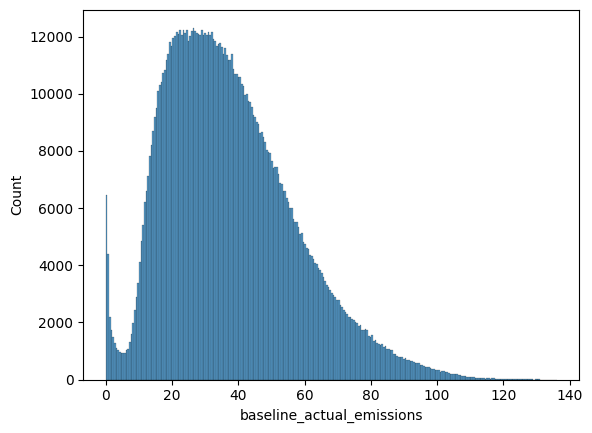

In [8]:
# near zero values unlikely, data error?
sns.histplot(results_data.baseline_actual_emissions)

## Largest Possible Gain from Simple Optimization
- run the simple optimizer on actual emissions data
- subtract from baseline

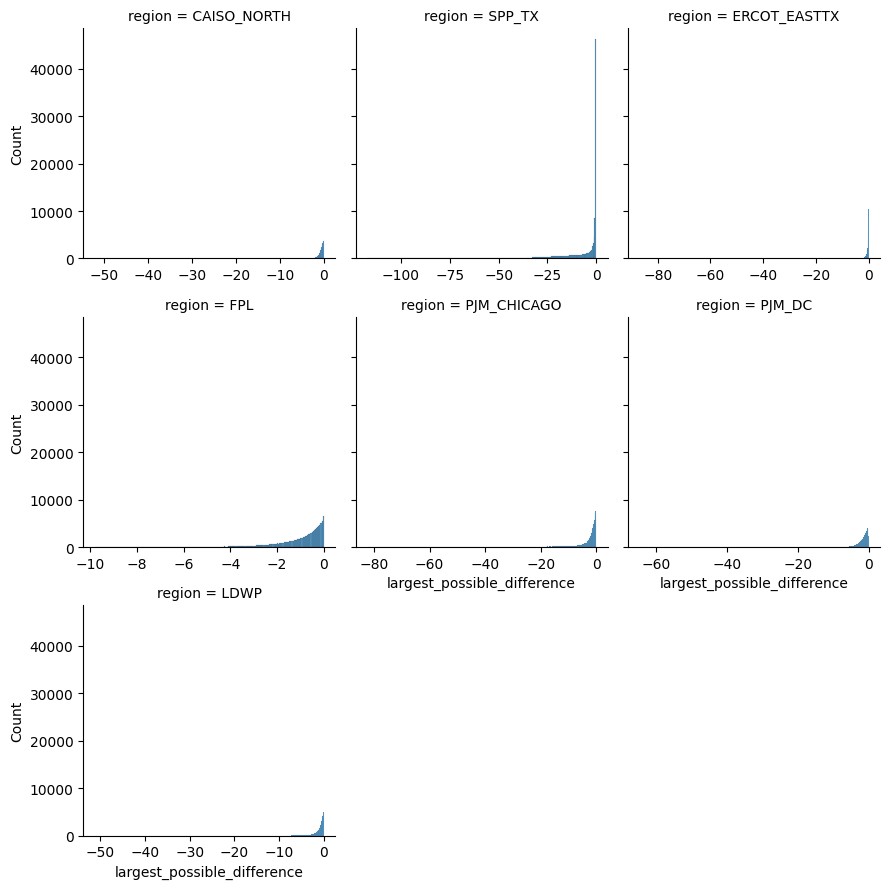

In [10]:
g = sns.FacetGrid(results_data.query('largest_possible_difference != 0'), col="region",sharex=False, col_wrap=3)
g.map(sns.histplot,"largest_possible_difference")

With perfect foresight, using the simple optimizer, what's the most emissions we can avoid in total for all users in each region?

In [11]:
results_data.groupby("region")["largest_possible_difference"].sum()

region
CAISO_NORTH     -85483.504532
ERCOT_EASTTX   -172364.661388
FPL            -115816.834650
LDWP           -129279.929052
PJM_CHICAGO    -498689.538093
PJM_DC         -178019.981538
SPP_TX         -892227.225518
Name: largest_possible_difference, dtype: float64

In [12]:
results_data.groupby('region')["optimization_possible"].value_counts(normalize=True)

region        optimization_possible
CAISO_NORTH   True                     0.693883
              False                    0.306117
ERCOT_EASTTX  True                     0.680982
              False                    0.319018
FPL           True                     0.694724
              False                    0.305276
LDWP          True                     0.692055
              False                    0.307945
PJM_CHICAGO   True                     0.696055
              False                    0.303945
PJM_DC        True                     0.695914
              False                    0.304086
SPP_TX        True                     0.688417
              False                    0.311583
Name: proportion, dtype: float64

Correlated with number of intervals plugged in.

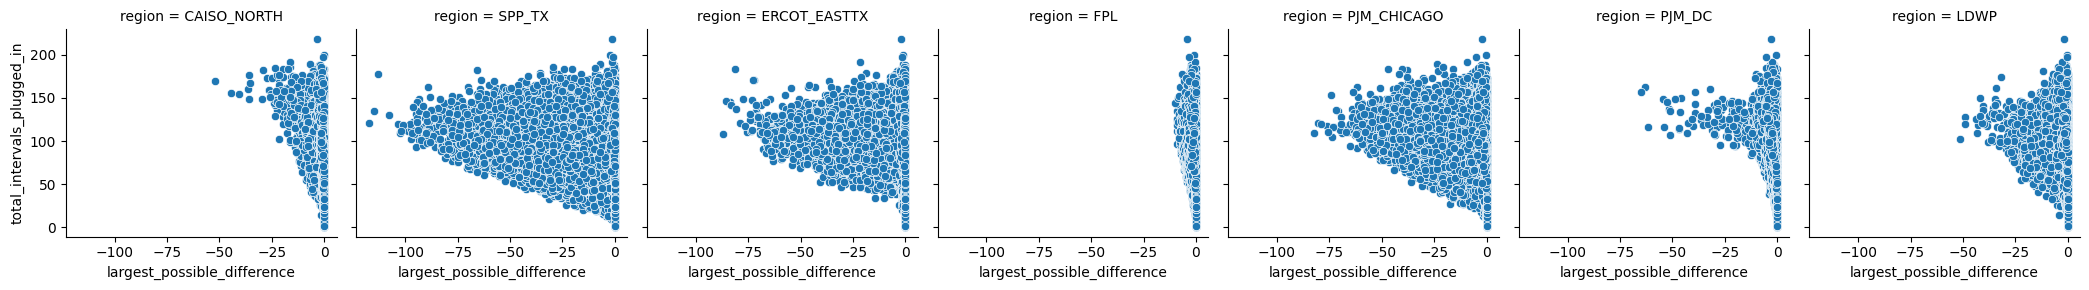

In [13]:
g = sns.FacetGrid(results_data, col="region")
g.map(sns.scatterplot,"largest_possible_difference", "total_intervals_plugged_in")

correlated with power output rate

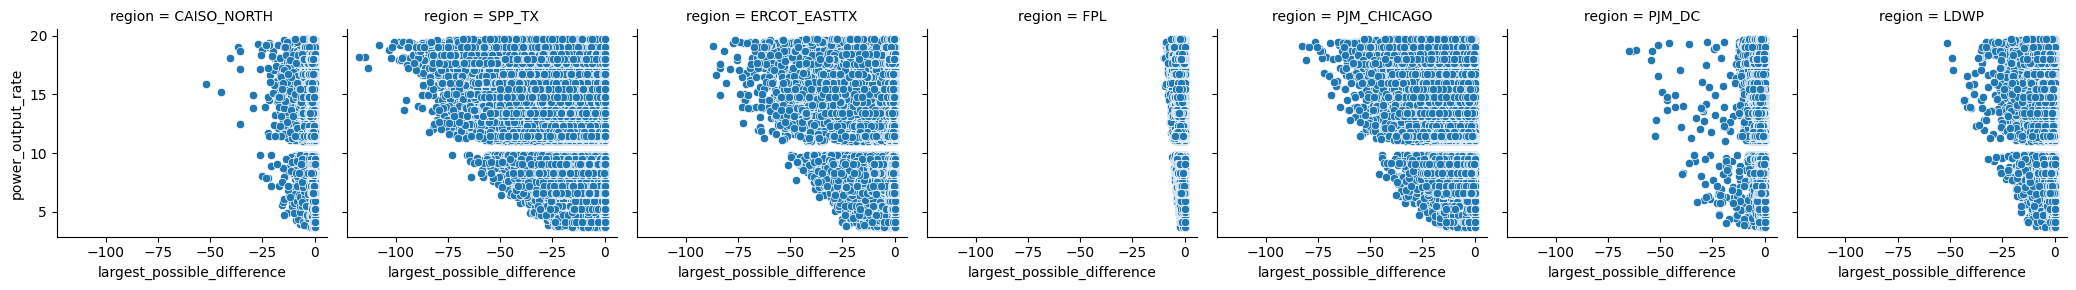

In [14]:
g = sns.FacetGrid(results_data, col="region")
g.map(sns.scatterplot,"largest_possible_difference", "power_output_rate")

- normalize the difference to account for variation in power output rate
For each region, the minimum amount of time plugged in to see benefit varies for an "overnight" charge. 
- For DC, we see that you often need to be plugged in for a longer timespan to optimize, whereas ERCOT East is about 1/2 that time. (when observing the theoretical)

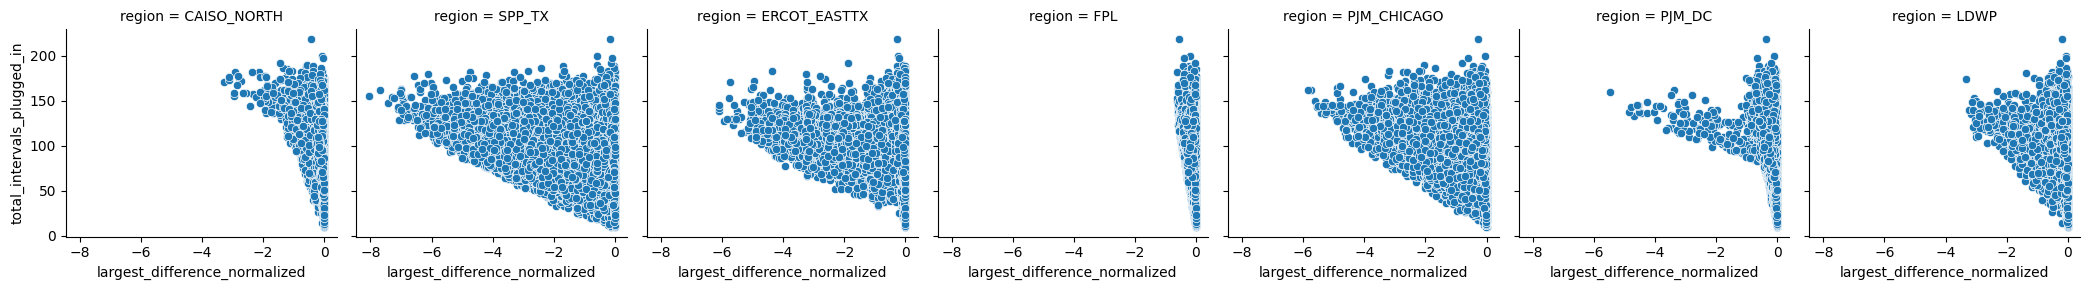

In [15]:
# things get interesting when you're plugged in for over 4 hours. Could reexpress this as odds.
g = sns.FacetGrid(results_data.query('largest_difference_normalized < 0'), col="region")
g.map(sns.scatterplot,"largest_difference_normalized", "total_intervals_plugged_in")

## Optimization Achieved
- baseline difference  = simple optimization "actual" emissions / baseline "actual" emissions
- percent of ideal = baseline difference / largest_possible_difference
- it's possible to accidently consume more emissions that baseline with the optimizer.

<Axes: xlabel='distinct_dates', ylabel='baseline_difference'>

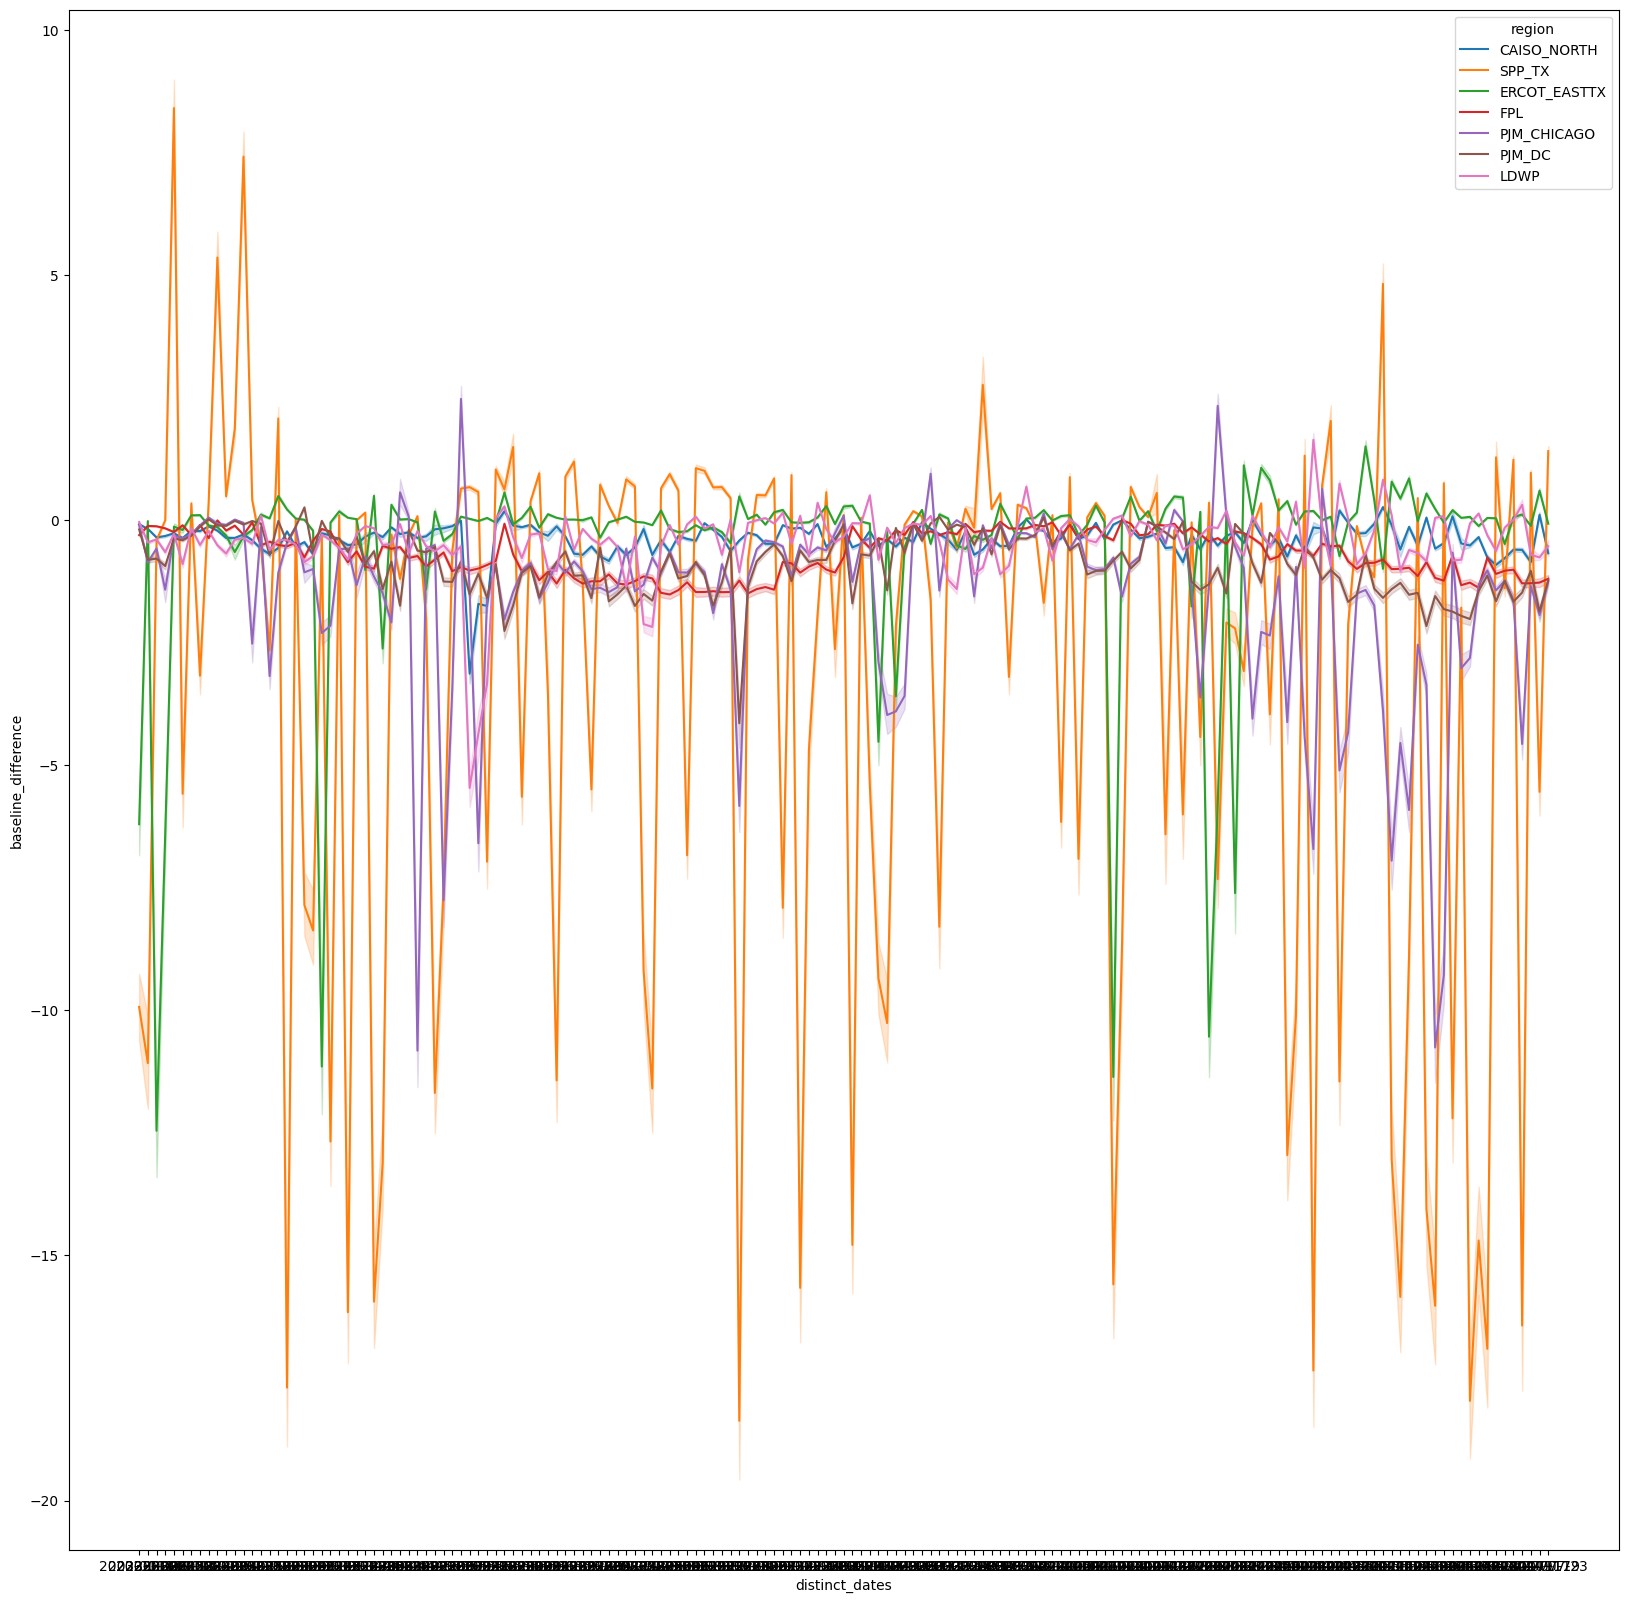

In [16]:
# positive is bad, negative is good
# summing all users for that day in that region - a different viz could be % users who optimized that day in that region.
plt.figure(figsize=(20, 20))
sns.lineplot(results_data, y="baseline_difference",x="distinct_dates", hue="region")

In [18]:
results_data.groupby('region')['baseline_difference'].describe()

,count,mean,std,min,25%,50%,75%,max
region,,,,,,,,
CAISO_NORTH,163000.0,-0.383949,0.920400,-52.093452,-0.539723,-0.113400,0.000000,12.359026
ERCOT_EASTTX,163000.0,-0.491308,3.634896,-78.659504,-0.082582,0.000000,0.063218,14.302337
FPL,163000.0,-0.680763,1.005167,-9.727685,-0.984817,-0.254528,0.000000,0.587560
LDWP,163000.0,-0.429256,1.409061,-49.564619,-0.554707,-0.038460,0.000000,12.587863
PJM_CHICAGO,163000.0,-1.513268,3.846402,-68.006389,-1.601149,-0.288621,0.000000,28.180152
PJM_DC,163000.0,-0.872203,1.418837,-51.870362,-1.289354,-0.300251,0.000000,2.553672
SPP_TX,163000.0,-3.272907,10.177693,-114.718296,-0.887035,0.000000,0.237822,61.711650


<Axes: xlabel='region'>

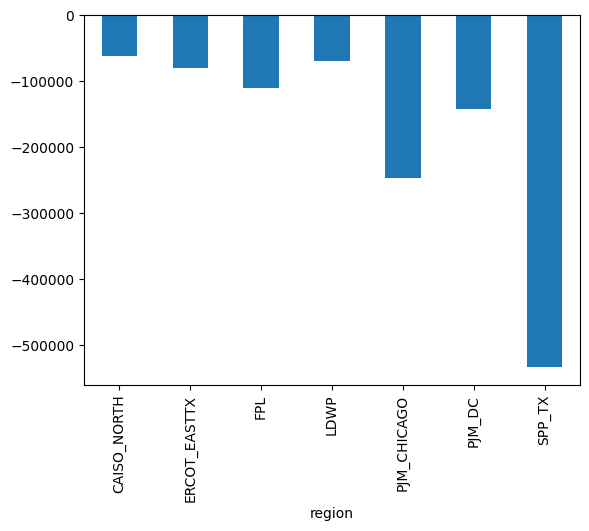

In [17]:
# may look different after cleaning up the data? We should perhaps check the historic actuals for missing values
results_data.groupby('region')['baseline_difference'].sum().plot(kind="bar")

In [19]:
round(results_data['largest_possible_difference'].replace(),2).describe()

/tmp/ipykernel_2212397/845058537.py:1: FutureWarning: Series.replace without 'value' and with non-dict-like 'to_replace' is deprecated and will raise in a future version. Explicitly specify the new values instead.
  round(results_data['largest_possible_difference'].replace(),2).describe()


count    1.141000e+06
mean    -1.815843e+00
std      5.625969e+00
min     -1.174400e+02
25%     -1.160000e+00
50%     -2.900000e-01
75%      0.000000e+00
max      0.000000e+00
Name: largest_possible_difference, dtype: float64

In [20]:
results_data['percent_ideal_achieved'] = np.divide(
    results_data['baseline_difference'],
    results_data['largest_possible_difference'],
    )
results_data['percent_ideal_achieved'] = results_data['percent_ideal_achieved'].replace([np.inf, -np.inf], np.nan)

In [21]:
# these look a bit fishy to me? Not sure...
results_data.groupby('region')['percent_ideal_achieved'].describe()

,count,mean,std,min,25%,50%,75%,max
region,,,,,,,,
CAISO_NORTH,113103.0,-0.296344,16.104362,-1677.0,0.443965,0.816054,0.941927,1.0
ERCOT_EASTTX,111000.0,-7.315431,64.347369,-5061.0,-1.365028,0.006393,0.501748,1.0
FPL,113240.0,0.410442,9.190694,-1041.0,0.908438,0.988490,0.999955,1.0
LDWP,112805.0,-3.206601,211.384730,-44143.0,0.050334,0.584401,0.853831,1.0
PJM_CHICAGO,113457.0,0.408953,4.951012,-1447.0,0.329154,0.706173,0.910952,1.0
PJM_DC,113434.0,0.395231,8.048179,-712.5,0.503557,0.803365,0.932989,1.0
SPP_TX,112212.0,-14.318664,176.211648,-30542.0,-2.666667,0.006863,0.775722,1.0


- overnight opportunity for improvement vary by region?
- FPL little variation in energy mix
- CAISO missing daynight solar for overnight test cases

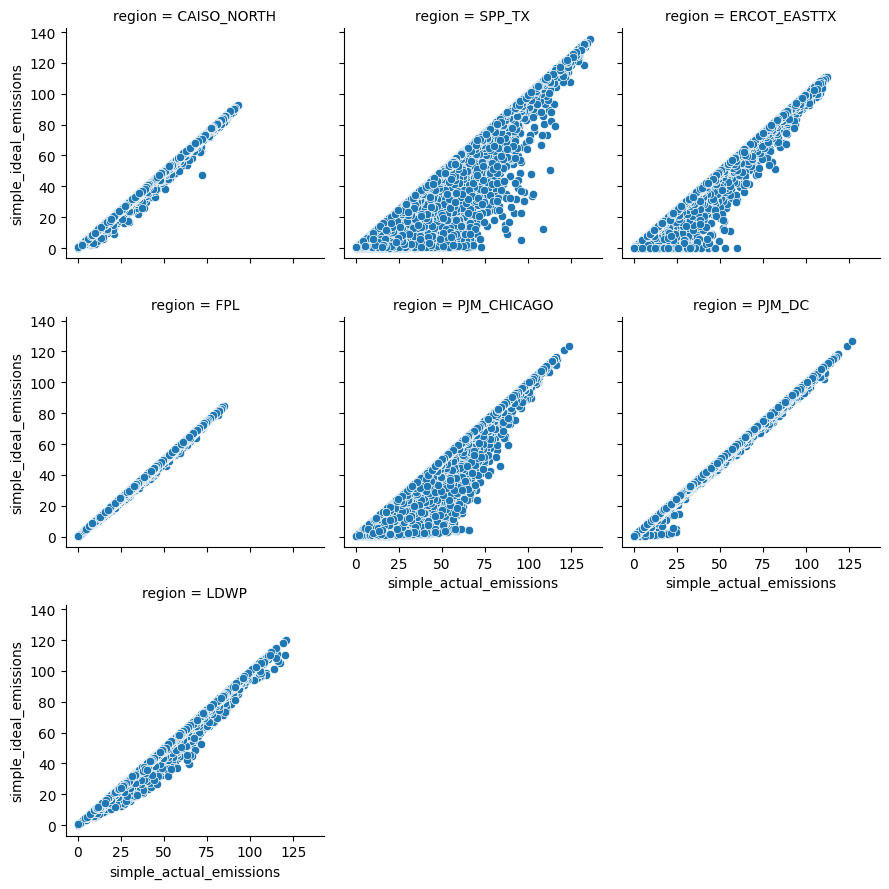

In [22]:
g = sns.FacetGrid(results_data, col="region", col_wrap = 3)
g.map(sns.scatterplot,"simple_actual_emissions", "simple_ideal_emissions")

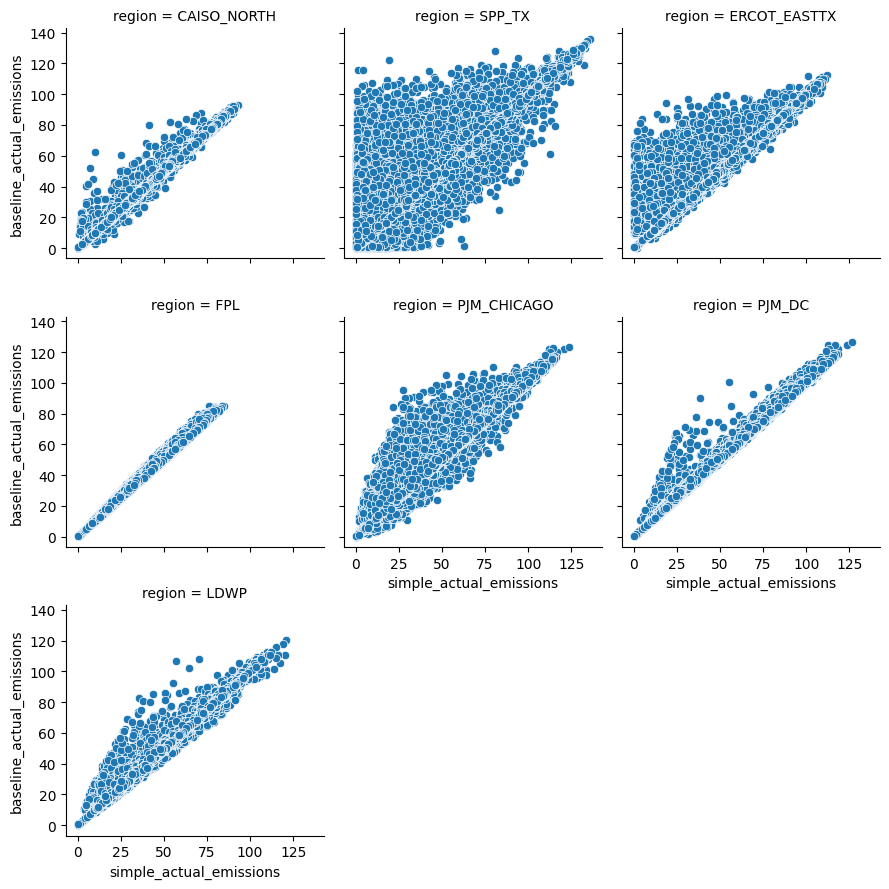

In [23]:
g = sns.FacetGrid(results_data, col="region", col_wrap = 3)
g.map(sns.scatterplot,"simple_actual_emissions", "baseline_actual_emissions")